# Conjugate fix test
Created 29/05/2024

Objectives:
* Try optimisation again now that bug has been fixed.

# Package imports

In [1]:
import sys

In [2]:
sys.path.append("../../")

In [3]:
from itertools import chain
import re

from collections import Counter, namedtuple

In [4]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os

In [5]:
import numpy as np
from jax import numpy as jnp

import matplotlib.pyplot as plt

import scipy

In [6]:
import quimb as qu
import quimb.tensor as qtn
from quimb.tensor.optimize import TNOptimizer

/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:54: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:36: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:73: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(


# Load data

In [7]:
DATA_DIR_1 = r"../../data/interpolated_trivial_to_nontrivial_fermionic_trivial_proj_rep_200_site_dmrg/"
DATA_DIR_2 = r"../../data/interpolated_nontrivial_fermionic_proj_rep_to_nontrivial_proj_rep_200_site_dmrg/"

In [8]:
def parse_file_name(file_name):
    interpolation = int(file_name.split('_')[0])/100

    return interpolation

In [9]:
loaded_data_non_triv_proj_rep = dict()
energies_non_triv_proj_rep = dict()

for local_file_name in list(os.walk(DATA_DIR_2))[0][2]:
    f_name = r"{}/{}".format(DATA_DIR_2, local_file_name, ignore_unknown=False)

    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)

        data_info = parse_file_name(local_file_name)
        loaded_data_non_triv_proj_rep[data_info]=data['wavefunction']
        energies_non_triv_proj_rep[data_info]=data['energy']

In [10]:
psi = loaded_data_non_triv_proj_rep[0]

In [11]:
Counter(
    tuple(psi.get_B(i).get_leg_labels())
    for i in range(psi.L)
)

Counter({('vL', 'p', 'vR'): 200})

In [12]:
psi_arrays = list()
psi_arrays.append(psi.get_B(0, 'Th')[0, ...].to_ndarray())
for i in range(1, psi.L-1):
    psi_arrays.append(psi.get_B(i).to_ndarray())
psi_arrays.append(psi.get_B(psi.L-1)[..., 0].to_ndarray())

In [13]:
q1 = (
    qtn
    .tensor_1d
    .MatrixProductState(
        psi_arrays,
        shape='lpr'
    )
)

# Definitions

## Define tensor network to contract against

In [14]:
np_10 = np.array([
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])

In [15]:
q2 = q1.copy(deep=True)

symmetry_sites = list(range(60, 60+80, 2))
for i in symmetry_sites:

    q2.gate(
        np_10,
        where=i,
        contract=False,
        inplace=True
    )

In [16]:
def generate_problem_rdm(quimb_psi, symmetry_site_pairs, leftmost_symmetry_site,
                         num_symmetry_sites, num_boundary_sites):
    q_top = quimb_psi.copy(deep=True)
    for i, s in symmetry_site_pairs:
        q_top.gate(
            s,
            where=i,
            contract=False,
            inplace=True
        )

    
    indices_to_map = list(chain(
        range(leftmost_symmetry_site-num_boundary_sites, leftmost_symmetry_site),
        range(leftmost_symmetry_site+num_symmetry_sites, leftmost_symmetry_site+num_symmetry_sites+num_boundary_sites)
    ))

    index_mapping = {f'k{i}': f'b{i}' for i in indices_to_map}

    q_bottom = (
        quimb_psi
        .copy()
        .reindex(index_mapping, inplace=True)
        .conj()
    )

    sites_to_contract = {
        'left': list(range(leftmost_symmetry_site-num_boundary_sites)),
        'middle': list(range(leftmost_symmetry_site, leftmost_symmetry_site+num_symmetry_sites)),
        'right': list(range(leftmost_symmetry_site+num_symmetry_sites+num_boundary_sites, quimb_psi.L))
    }

    tags_to_contract = {
        k: [f'I{i}' for i in v]
        for k, v in sites_to_contract.items()
    }

    tn = (q_top & q_bottom)

    tnc = (
        tn
        .contract(tags_to_contract['left'])
        .contract(tags_to_contract['middle'])
        .contract(tags_to_contract['right'])
    )

    return tnc

In [17]:
symmetry_site_pairs = [
    (i, np_10) for i in range(60, 60+80, 2)
]

problem_rdm = generate_problem_rdm(
    q1,
    symmetry_site_pairs,
    60,
    80,
    6
)

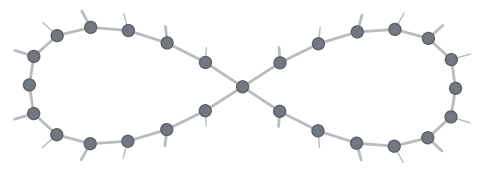

In [18]:
problem_rdm.draw()

## Initialize mpo functions

In [19]:
num_boundary_sites=6
left_most_symmetry_site=60
num_symmetry_sites=80
bond_dimension=6

In [20]:
def initialize_mpo(left_most_symmetry_site, num_symmetry_sites,
                   num_boundary_sites, bond_dimension, phys_dim=[4,2]):
    # Kind of hard coding the physical dimensions.
    ml = qtn.MPO_rand(
        num_boundary_sites,
        bond_dimension,
        phys_dim=phys_dim,
        normalize=True,
        sites=list(range(left_most_symmetry_site-num_boundary_sites, left_most_symmetry_site)),
        dtype=np.complex128,
        tags='left_mpo'
    )

    mr = qtn.MPO_rand(
        num_boundary_sites,
        bond_dimension,
        phys_dim=phys_dim,
        normalize=True,
        sites=list(range(
            left_most_symmetry_site + num_symmetry_sites,
            left_most_symmetry_site + num_symmetry_sites + num_boundary_sites
        )),
        dtype=np.complex128,
        tags='right_mpo'
    )

    mpo = (ml & mr)

    return mpo

## Optimisation functions

In [21]:
def split_mpo_pair(mpo_pair):
    ml = qtn.TensorNetwork(
        list(map(mpo_pair.tensor_map.__getitem__, mpo.tag_map['left_mpo']))
    )

    mr = qtn.TensorNetwork(
        list(map(mpo_pair.tensor_map.__getitem__, mpo.tag_map['right_mpo']))
    )

    return (ml, mr)

In [22]:
def overlap_loss_function(ml, mr, rdm_tn, epsilon=1e-8):
    c = (rdm_tn & ml & mr) ^ ...

    c_abs_squared = (
        c
        *jnp.conjugate(c)
    )
    #c_abs_squared = c_abs_squared.astype('float32')
    c_abs = (jnp.sqrt(c_abs_squared+epsilon))

    target = jnp.sqrt(1+epsilon)
    loss = (c_abs - target)**2

    return loss

In [23]:
def overlap_loss_function_mpo_pair(mpo_pair, rdm_tn):
    ml, mr = split_mpo_pair(mpo_pair)

    return overlap_loss_function(ml, mr, rdm_tn)

In [24]:
total_physical_dim = 2**9

In [25]:
regex_s = r"^I\d+$"
regex_p = re.compile(regex_s)

In [26]:
def relabel_mpo(mpo, k_label, b_label):
    site_locs = [
        int(k[1:]) for k in mpo.tag_map
        if bool(re.search(regex_p, k))
    ]

    k_in_indices = [f'k{i}' for i in site_locs]
    j_in_indices = [f'b{i}' for i in site_locs]

    k_out_indices = [f'{k_label}{i}' for i in site_locs]
    j_out_indices = [f'{b_label}{i}' for i in site_locs]

    mapping = dict(
        chain(
            zip(k_in_indices, k_out_indices),
            zip(j_in_indices, j_out_indices)
        )
    )

    mpo.reindex(mapping, inplace=True)

In [27]:
def unitarity_tn(tn, total_physical_dim):
    ms = [tn.copy(), tn.copy(), tn.copy()]

    relabel_mpo(ms[0], 'k', 'l')
    relabel_mpo(ms[1], 'm', 'l')
    relabel_mpo(ms[2], 'm', 'b')

    ms[0] = ms[0].conj()
    ms[2] = ms[2].conj()

    n2tn = (tn & tn.conj())
    n2 = n2tn.contract(n2tn.tag_map)
    n4tn = (tn & ms[0] & ms[1] & ms[2])
    n4 = n4tn.contract(n4tn.tag_map)

    out = jnp.real(n4 - 2*n2 + total_physical_dim)

    return out

In [28]:
def overall_loss_function(mpo_pair, rdm_tn, total_physical_dimension,
    unitary_cost_coefficient=1, overlap_cost_coefficient=1, losses=None):
    ml, mr = split_mpo_pair(mpo_pair)

    o_loss = overlap_loss_function(ml, mr, rdm_tn)
    ul_loss = jnp.sqrt(1 + unitarity_tn(ml, total_physical_dimension)) - 1
    ur_loss = jnp.sqrt(1 + unitarity_tn(mr, total_physical_dimension)) - 1

    out = (
        unitary_cost_coefficient*(ul_loss+ur_loss)
        + overlap_cost_coefficient*o_loss
    )

    out = jnp.real(out)

    if losses is not None:
        losses.append((o_loss, ul_loss, ur_loss))
    return out

# Runs
## 1

In [29]:
total_physical_dim = 2**9

In [30]:
num_iterations = int(1e4) 
num_seeds = 10

hyperparameter_dists_dict = {
    'alpha': scipy.stats.loguniform(1e-4, 1e-2),
    'beta_1': scipy.stats.uniform(0.1, 0.5),
    'beta_2': scipy.stats.uniform(0.1, 0.5),
    'bond_dimension': scipy.stats.randint(4, 9),
    'overlap_learning_rate': scipy.stats.randint(1, 500)
}

In [31]:
HyperParams = namedtuple('HyperParams', hyperparameter_dists_dict)

In [32]:
optimizers = dict()

for _ in range(num_seeds):
    hyperparams ={k: v.rvs() for k, v in hyperparameter_dists_dict.items()}

    mpo = initialize_mpo(
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites,
        hyperparams['bond_dimension']
    )

    optmzr = qtn.optimize.TNOptimizer(
        mpo,                                # our initial input, the tensors of which to optimize
        loss_fn=overall_loss_function,
        loss_kwargs={
            'rdm_tn': problem_rdm,
            'total_physical_dimension': total_physical_dim,
            'unitary_cost_coefficient': 1,
            'overlap_cost_coefficient': hyperparams['overlap_learning_rate']
        },
        autodiff_backend='jax',      # {'jax', 'tensorflow', 'autograd'}
        optimizer='adam',               # supplied to scipy.minimize
    )

    optmzr.optimize(
        num_iterations,
        learning_rate=hyperparams['alpha'],
        beta1=hyperparams['beta_1'],
        beta2=hyperparams['beta_2']
    )

    optimizers[HyperParams(**hyperparams)] = optmzr

  0%|                                                                                                                                                                             | 0/10000 [00:00<?, ?it/s]/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from complex64 to complex128.
  warnings.warn(
+0.289836734533 [best: +0.289064407349] : : 10001it [00:32, 309.93it/s]                                                                                                                                     
+0.031309437007 [best: +0.025662513450] : : 10001it [00:44, 226.74it/s]                                                                                 

In [33]:
optimizers

{HyperParams(alpha=0.0003527868113358006, beta_1=0.5107455278133517, beta_2=0.17154220749055096, bond_dimension=5, overlap_learning_rate=157): <TNOptimizer(d=4400, backend=jax)>,
 HyperParams(alpha=0.00032644692903256825, beta_1=0.5998886667880403, beta_2=0.23445574218166917, bond_dimension=6, overlap_learning_rate=264): <TNOptimizer(d=6240, backend=jax)>,
 HyperParams(alpha=0.001021604097916268, beta_1=0.36688536975811303, beta_2=0.2927991010986811, bond_dimension=8, overlap_learning_rate=494): <TNOptimizer(d=10880, backend=jax)>,
 HyperParams(alpha=0.002602580018593497, beta_1=0.13604120537827266, beta_2=0.4090192128021942, bond_dimension=8, overlap_learning_rate=145): <TNOptimizer(d=10880, backend=jax)>,
 HyperParams(alpha=0.005787910539264576, beta_1=0.5800341357833815, beta_2=0.42921578994834464, bond_dimension=4, overlap_learning_rate=267): <TNOptimizer(d=2880, backend=jax)>,
 HyperParams(alpha=0.006737917506848873, beta_1=0.17709198387678174, beta_2=0.17708229685331447, bond_dim

In [34]:
optimizer_list = [
    (k, v) for k, v in optimizers.items()
]

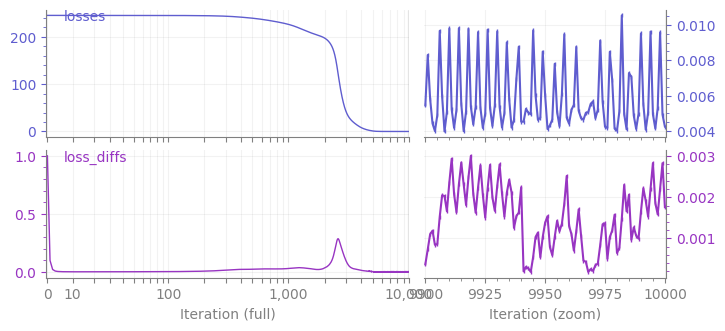

(<Figure size 800x348.22 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='Iteration (full)'>,
         <Axes: xlabel='Iteration (zoom)'>]], dtype=object))

In [35]:
optimizer_list[7][1].plot()

In [37]:
final_scores = list()

for h, o in optimizer_list:
    mpo_opt = o.get_tn_opt()
    ml, mr = split_mpo_pair(mpo_opt)

    out = (
        overlap_loss_function(ml, mr, problem_rdm),
        unitarity_tn(ml, total_physical_dim),
        unitarity_tn(mr, total_physical_dim),
    )

    final_scores.append(out)

In [38]:
final_scores

[(Array(0.00031815-3.8481128e-11j, dtype=complex64),
  Array(0.22692871, dtype=float32, weak_type=True),
  Array(0.28216553, dtype=float32, weak_type=True)),
 (Array(8.0705286e-07-5.5740135e-13j, dtype=complex64),
  Array(0.03479004, dtype=float32, weak_type=True),
  Array(0.02764893, dtype=float32, weak_type=True)),
 (Array(0.00064576-7.077168e-11j, dtype=complex64),
  Array(0.20492554, dtype=float32, weak_type=True),
  Array(0.33428955, dtype=float32, weak_type=True)),
 (Array(0.0055762-5.8411215e-10j, dtype=complex64),
  Array(2.8183594, dtype=float32, weak_type=True),
  Array(2.5352173, dtype=float32, weak_type=True)),
 (Array(0.00032815+1.5696819e-10j, dtype=complex64),
  Array(0.2585144, dtype=float32, weak_type=True),
  Array(0.30334473, dtype=float32, weak_type=True)),
 (Array(0.00925412-2.5553303e-11j, dtype=complex64),
  Array(3.669464, dtype=float32, weak_type=True),
  Array(4.4055176, dtype=float32, weak_type=True)),
 (Array(0.00128208+5.1208543e-10j, dtype=complex64),
  Ar

## 2 - Harder case

In [39]:
psi = loaded_data_non_triv_proj_rep[0.45]

In [40]:
Counter(
    tuple(psi.get_B(i).get_leg_labels())
    for i in range(psi.L)
)

Counter({('vL', 'p', 'vR'): 200})

In [41]:
psi_arrays = list()
psi_arrays.append(psi.get_B(0, 'Th')[0, ...].to_ndarray())
for i in range(1, psi.L-1):
    psi_arrays.append(psi.get_B(i).to_ndarray())
psi_arrays.append(psi.get_B(psi.L-1)[..., 0].to_ndarray())

In [42]:
q1 = (
    qtn
    .tensor_1d
    .MatrixProductState(
        psi_arrays,
        shape='lpr'
    )
)

In [45]:
np_01 = np.array([
    [0, 1, 0, 0],
    [1, 0, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0]
])


np_JW = np.array([
    [1, 0],
    [0, -1]
])

In [48]:
symmetry_site_pairs = (
    [(i, np_01) for i in range(60, 60+80, 2)]
    + [(i, np_JW) for i in range(61, 61+80, 2)]
)

In [49]:
problem_rdm = generate_problem_rdm(
    q1,
    symmetry_site_pairs,
    60,
    80,
    10
)

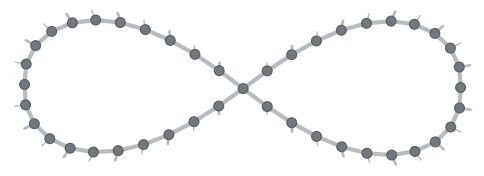

In [50]:
problem_rdm.draw()

In [51]:
total_physical_dim = 2**(3*5)

In [52]:
num_iterations = int(1e4) 
num_seeds = 10

hyperparameter_dists_dict = {
    'alpha': scipy.stats.loguniform(1e-4, 1e-2),
    'beta_1': scipy.stats.uniform(0.1, 0.5),
    'beta_2': scipy.stats.uniform(0.1, 0.5),
    'bond_dimension': scipy.stats.randint(4, 8),
    'overlap_learning_rate': scipy.stats.randint(100, 500)
}

In [53]:
HyperParams = namedtuple('HyperParams', hyperparameter_dists_dict)

In [54]:
left_most_symmetry_site=60
num_symmetry_sites=80
num_boundary_sites=10

In [55]:
optimizers = dict()

for _ in range(num_seeds):
    hyperparams ={k: v.rvs() for k, v in hyperparameter_dists_dict.items()}

    mpo = initialize_mpo(
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites,
        hyperparams['bond_dimension']
    )

    optmzr = qtn.optimize.TNOptimizer(
        mpo,                                # our initial input, the tensors of which to optimize
        loss_fn=overall_loss_function,
        loss_kwargs={
            'rdm_tn': problem_rdm,
            'total_physical_dimension': total_physical_dim,
            'unitary_cost_coefficient': 1,
            'overlap_cost_coefficient': hyperparams['overlap_learning_rate']
        },
        autodiff_backend='jax',      # {'jax', 'tensorflow', 'autograd'}
        optimizer='adam',               # supplied to scipy.minimize
    )

    optmzr.optimize(
        num_iterations,
        learning_rate=hyperparams['alpha'],
        beta1=hyperparams['beta_1'],
        beta2=hyperparams['beta_2']
    )

    optimizers[HyperParams(**hyperparams)] = optmzr

  0%|                                                                                                                                                                             | 0/10000 [00:00<?, ?it/s]/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from complex64 to complex128.
  warnings.warn(
+534.825378417969 [best: +497.240661621094] : : 10001it [01:46, 94.29it/s]                                                                                                                                  
+178.591415405273 [best: +174.603851318359] : : 10001it [03:05, 53.97it/s]                                                                              

In [56]:
optimizers

{HyperParams(alpha=0.0030651925885528605, beta_1=0.39754320779631824, beta_2=0.574751550067667, bond_dimension=6, overlap_learning_rate=489): <TNOptimizer(d=12000, backend=jax)>,
 HyperParams(alpha=0.0009817525786692085, beta_1=0.2936677133658525, beta_2=0.21111039300925324, bond_dimension=7, overlap_learning_rate=154): <TNOptimizer(d=16240, backend=jax)>,
 HyperParams(alpha=0.0071635838331081106, beta_1=0.17446971717660584, beta_2=0.11566541974888392, bond_dimension=5, overlap_learning_rate=307): <TNOptimizer(d=8400, backend=jax)>,
 HyperParams(alpha=0.0013772206386231023, beta_1=0.40879578485892154, beta_2=0.11137363799934094, bond_dimension=5, overlap_learning_rate=330): <TNOptimizer(d=8400, backend=jax)>,
 HyperParams(alpha=0.001121348204433384, beta_1=0.3776734808450203, beta_2=0.365569514084491, bond_dimension=7, overlap_learning_rate=293): <TNOptimizer(d=16240, backend=jax)>,
 HyperParams(alpha=0.0067166715851431705, beta_1=0.5000256707792111, beta_2=0.2536443278403968, bond_dim

In [57]:
optimizer_list = [
    (k, v) for k, v in optimizers.items()
]

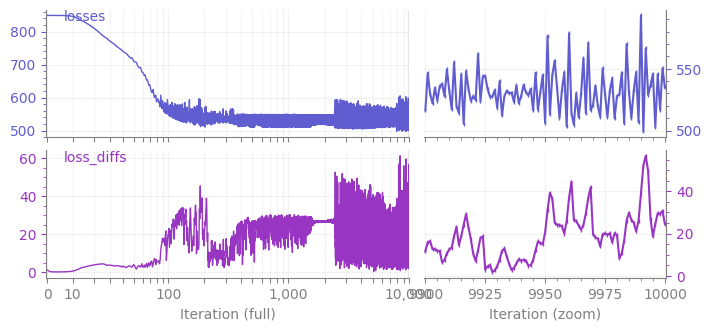

(<Figure size 800x348.22 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='Iteration (full)'>,
         <Axes: xlabel='Iteration (zoom)'>]], dtype=object))

In [58]:
optimizer_list[0][1].plot()

In [59]:
optimizer_list[0][0]

HyperParams(alpha=0.0030651925885528605, beta_1=0.39754320779631824, beta_2=0.574751550067667, bond_dimension=6, overlap_learning_rate=489)

In [60]:
final_scores = list()

for h, o in optimizer_list:
    mpo_opt = o.get_tn_opt()
    ml, mr = split_mpo_pair(mpo_opt)

    out = (
        overlap_loss_function(ml, mr, problem_rdm),
        unitarity_tn(ml, total_physical_dim),
        unitarity_tn(mr, total_physical_dim),
    )

    final_scores.append(out)

In [61]:
final_scores

[(Array(0.99999416+1.7142905e-14j, dtype=complex64),
  Array(324.32422, dtype=float32, weak_type=True),
  Array(886.7578, dtype=float32, weak_type=True)),
 (Array(0.999998-2.7797618e-16j, dtype=complex64),
  Array(249.78906, dtype=float32, weak_type=True),
  Array(114.49219, dtype=float32, weak_type=True)),
 (Array(0.9999964+7.52493e-15j, dtype=complex64),
  Array(5985.6953, dtype=float32, weak_type=True),
  Array(5356.2705, dtype=float32, weak_type=True)),
 (Array(0.999997-3.8672505e-15j, dtype=complex64),
  Array(39.441406, dtype=float32, weak_type=True),
  Array(74.61719, dtype=float32, weak_type=True)),
 (Array(0.99999774-4.809716e-16j, dtype=complex64),
  Array(180.08008, dtype=float32, weak_type=True),
  Array(161.74023, dtype=float32, weak_type=True)),
 (Array(0.99998975+1.0711314e-14j, dtype=complex64),
  Array(9885.43, dtype=float32, weak_type=True),
  Array(3620.5996, dtype=float32, weak_type=True)),
 (Array(0.99999464+1.6340341e-14j, dtype=complex64),
  Array(29.4375, dtype=

In [64]:
optimizer_list[-1][0]

HyperParams(alpha=0.0001746125064809705, beta_1=0.4992309792949742, beta_2=0.5462107511981655, bond_dimension=5, overlap_learning_rate=346)

## 3

In [62]:
total_physical_dim = 2**(3*5)

In [63]:
np.sqrt(total_physical_dim)

181.01933598375618

In [67]:
num_iterations = int(1e4) 
num_seeds = 10

hyperparameter_dists_dict = {
    'alpha': scipy.stats.loguniform(1e-5, 1e-3),
    'beta_1': scipy.stats.uniform(0.2, 0.6),
    'beta_2': scipy.stats.uniform(0.2, 0.6),
    'bond_dimension': scipy.stats.randint(4, 8),
    'overlap_learning_rate': scipy.stats.randint(200, 800)
}

In [68]:
HyperParams = namedtuple('HyperParams', hyperparameter_dists_dict)

In [69]:
left_most_symmetry_site=60
num_symmetry_sites=80
num_boundary_sites=10

In [70]:
optimizers = dict()

for _ in range(num_seeds):
    hyperparams ={k: v.rvs() for k, v in hyperparameter_dists_dict.items()}

    mpo = initialize_mpo(
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites,
        hyperparams['bond_dimension']
    )

    optmzr = qtn.optimize.TNOptimizer(
        mpo,                                # our initial input, the tensors of which to optimize
        loss_fn=overall_loss_function,
        loss_kwargs={
            'rdm_tn': problem_rdm,
            'total_physical_dimension': total_physical_dim,
            'unitary_cost_coefficient': 1,
            'overlap_cost_coefficient': hyperparams['overlap_learning_rate']
        },
        autodiff_backend='jax',      # {'jax', 'tensorflow', 'autograd'}
        optimizer='adam',               # supplied to scipy.minimize
    )

    optmzr.optimize(
        num_iterations,
        learning_rate=hyperparams['alpha'],
        beta1=hyperparams['beta_1'],
        beta2=hyperparams['beta_2']
    )

    optimizers[HyperParams(**hyperparams)] = optmzr

  0%|                                                                                                                                                                             | 0/10000 [00:00<?, ?it/s]/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from complex64 to complex128.
  warnings.warn(
+289.015106201172 [best: +288.954162597656] : : 10001it [01:19, 125.83it/s]                                                                                                                                 
+685.930175781250 [best: +685.465148925781] : : 10001it [02:55, 56.92it/s]                                                                              

In [71]:
optimizer_list = [
    (k, v) for k, v in optimizers.items()
]

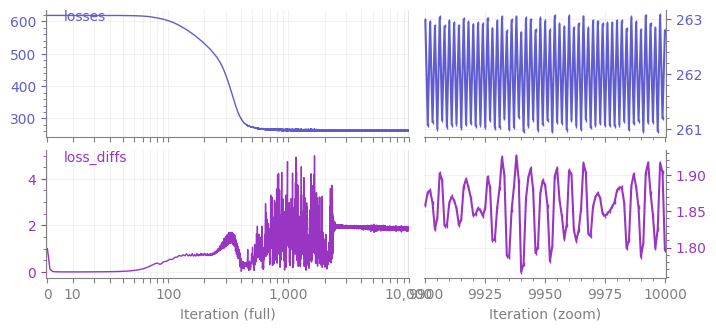

(<Figure size 800x348.22 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='Iteration (full)'>,
         <Axes: xlabel='Iteration (zoom)'>]], dtype=object))

In [72]:
optimizer_list[3][1].plot()

In [73]:
final_scores = list()

for h, o in optimizer_list:
    mpo_opt = o.get_tn_opt()
    ml, mr = split_mpo_pair(mpo_opt)

    out = (
        overlap_loss_function(ml, mr, problem_rdm),
        unitarity_tn(ml, total_physical_dim),
        unitarity_tn(mr, total_physical_dim),
    )

    final_scores.append(out)

In [74]:
final_scores

[(Array(0.99999726+8.225329e-16j, dtype=complex64),
  Array(1.1679688, dtype=float32, weak_type=True),
  Array(1.3945312, dtype=float32, weak_type=True)),
 (Array(0.99999785+5.4064583e-16j, dtype=complex64),
  Array(33.335938, dtype=float32, weak_type=True),
  Array(35.804688, dtype=float32, weak_type=True)),
 (Array(0.9999975-2.7519895e-15j, dtype=complex64),
  Array(0.41015625, dtype=float32, weak_type=True),
  Array(0.27929688, dtype=float32, weak_type=True)),
 (Array(0.9999926+1.2025221e-14j, dtype=complex64),
  Array(12.21875, dtype=float32, weak_type=True),
  Array(8.9765625, dtype=float32, weak_type=True)),
 (Array(0.9999956+4.525819e-15j, dtype=complex64),
  Array(1.078125, dtype=float32, weak_type=True),
  Array(4.6132812, dtype=float32, weak_type=True)),
 (Array(0.99999785+1.3006319e-15j, dtype=complex64),
  Array(70.16016, dtype=float32, weak_type=True),
  Array(48.527344, dtype=float32, weak_type=True)),
 (Array(0.999998-5.116149e-17j, dtype=complex64),
  Array(14.1796875, 

## 4 - 8 sites

In [76]:
problem_rdm = generate_problem_rdm(
    q1,
    symmetry_site_pairs,
    60,
    80,
    8
)

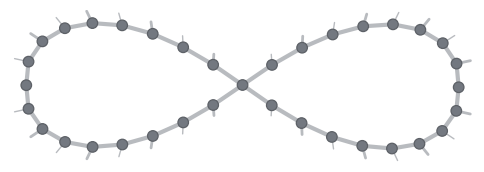

In [77]:
problem_rdm.draw()

In [78]:
total_physical_dim = 2**(3*4)

In [79]:
total_physical_dim

4096

In [80]:
num_iterations = int(1e4) 
num_seeds = 10

hyperparameter_dists_dict = {
    'alpha': scipy.stats.loguniform(1e-4, 1e-2),
    'beta_1': scipy.stats.uniform(0.1, 0.5),
    'beta_2': scipy.stats.uniform(0.1, 0.5),
    'bond_dimension': scipy.stats.randint(4, 8),
    'overlap_learning_rate': scipy.stats.randint(50, 500)
}

In [81]:
HyperParams = namedtuple('HyperParams', hyperparameter_dists_dict)

In [82]:
left_most_symmetry_site=60
num_symmetry_sites=80
num_boundary_sites=8

In [83]:
optimizers = dict()

for _ in range(num_seeds):
    hyperparams ={k: v.rvs() for k, v in hyperparameter_dists_dict.items()}

    mpo = initialize_mpo(
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites,
        hyperparams['bond_dimension']
    )

    optmzr = qtn.optimize.TNOptimizer(
        mpo,                                # our initial input, the tensors of which to optimize
        loss_fn=overall_loss_function,
        loss_kwargs={
            'rdm_tn': problem_rdm,
            'total_physical_dimension': total_physical_dim,
            'unitary_cost_coefficient': 1,
            'overlap_cost_coefficient': hyperparams['overlap_learning_rate']
        },
        autodiff_backend='jax',      # {'jax', 'tensorflow', 'autograd'}
        optimizer='adam',               # supplied to scipy.minimize
    )

    optmzr.optimize(
        num_iterations,
        learning_rate=hyperparams['alpha'],
        beta1=hyperparams['beta_1'],
        beta2=hyperparams['beta_2']
    )

    optimizers[HyperParams(**hyperparams)] = optmzr

  0%|                                                                                                                                                                             | 0/10000 [00:00<?, ?it/s]/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from complex64 to complex128.
  warnings.warn(
+291.015930175781 [best: +291.014648437500] : : 10001it [01:54, 87.24it/s]                                                                                                                                  
+18.330818176270 [best: +17.467185974121] : : 10001it [01:17, 128.86it/s]                                                                               

In [84]:
optimizer_list = [
    (k, v) for k, v in optimizers.items()
]

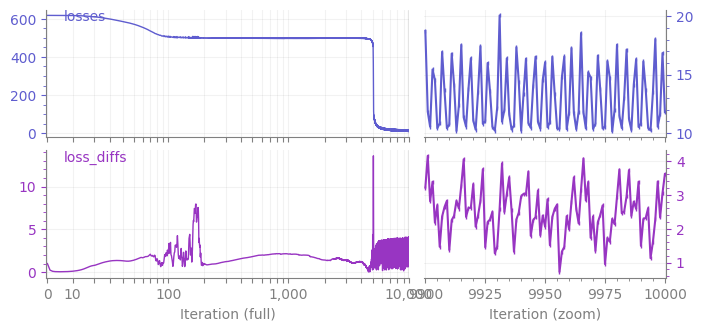

(<Figure size 800x348.22 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='Iteration (full)'>,
         <Axes: xlabel='Iteration (zoom)'>]], dtype=object))

In [85]:
optimizer_list[-2][1].plot()

In [86]:
optimizer_list[-2][0]

HyperParams(alpha=0.0027685207189339367, beta_1=0.44076034382630436, beta_2=0.31948130571906974, bond_dimension=5, overlap_learning_rate=491)

In [87]:
final_scores = list()

for h, o in optimizer_list:
    mpo_opt = o.get_tn_opt()
    ml, mr = split_mpo_pair(mpo_opt)

    out = (
        overlap_loss_function(ml, mr, problem_rdm),
        unitarity_tn(ml, total_physical_dim),
        unitarity_tn(mr, total_physical_dim),
    )

    final_scores.append(out)

In [88]:
final_scores

[(Array(0.99994874+1.5701977e-14j, dtype=complex64),
  Array(0.02050781, dtype=float32, weak_type=True),
  Array(0.04321289, dtype=float32, weak_type=True)),
 (Array(0.00878535-8.9514146e-11j, dtype=complex64),
  Array(73.194336, dtype=float32, weak_type=True),
  Array(60.103516, dtype=float32, weak_type=True)),
 (Array(0.9999498+1.6491566e-13j, dtype=complex64),
  Array(244.00586, dtype=float32, weak_type=True),
  Array(627.0801, dtype=float32, weak_type=True)),
 (Array(0.9997715+5.732379e-13j, dtype=complex64),
  Array(264.36035, dtype=float32, weak_type=True),
  Array(261.23193, dtype=float32, weak_type=True)),
 (Array(0.99990344-2.8591246e-13j, dtype=complex64),
  Array(0.24804688, dtype=float32, weak_type=True),
  Array(0.04443359, dtype=float32, weak_type=True)),
 (Array(0.0045766+4.586022e-11j, dtype=complex64),
  Array(172.91797, dtype=float32, weak_type=True),
  Array(120.623535, dtype=float32, weak_type=True)),
 (Array(0.01007916-8.183968e-10j, dtype=complex64),
  Array(74.28

## 5 - 6 sites

In [89]:
problem_rdm = generate_problem_rdm(
    q1,
    symmetry_site_pairs,
    60,
    80,
    6
)

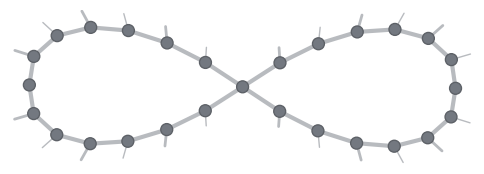

In [90]:
problem_rdm.draw()

In [92]:
total_physical_dim = 2**(3*3)

In [93]:
total_physical_dim

512

In [94]:
num_iterations = int(1e4) 
num_seeds = 10

hyperparameter_dists_dict = {
    'alpha': scipy.stats.loguniform(1e-4, 1e-2),
    'beta_1': scipy.stats.uniform(0.1, 0.5),
    'beta_2': scipy.stats.uniform(0.1, 0.5),
    'bond_dimension': scipy.stats.randint(4, 8),
    'overlap_learning_rate': scipy.stats.randint(50, 500)
}

In [95]:
HyperParams = namedtuple('HyperParams', hyperparameter_dists_dict)

In [96]:
left_most_symmetry_site=60
num_symmetry_sites=80
num_boundary_sites=6

In [97]:
optimizers = dict()

for _ in range(num_seeds):
    hyperparams ={k: v.rvs() for k, v in hyperparameter_dists_dict.items()}

    mpo = initialize_mpo(
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites,
        hyperparams['bond_dimension']
    )

    optmzr = qtn.optimize.TNOptimizer(
        mpo,                                # our initial input, the tensors of which to optimize
        loss_fn=overall_loss_function,
        loss_kwargs={
            'rdm_tn': problem_rdm,
            'total_physical_dimension': total_physical_dim,
            'unitary_cost_coefficient': 1,
            'overlap_cost_coefficient': hyperparams['overlap_learning_rate']
        },
        autodiff_backend='jax',      # {'jax', 'tensorflow', 'autograd'}
        optimizer='adam',               # supplied to scipy.minimize
    )

    optmzr.optimize(
        num_iterations,
        learning_rate=hyperparams['alpha'],
        beta1=hyperparams['beta_1'],
        beta2=hyperparams['beta_2']
    )

    optimizers[HyperParams(**hyperparams)] = optmzr

  0%|                                                                                                                                                                             | 0/10000 [00:00<?, ?it/s]/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from complex64 to complex128.
  warnings.warn(
+3.057345390320 [best: +2.859235763550] : : 10001it [00:28, 347.07it/s]                                                                                                                                     
+0.761290371418 [best: +0.761111438274] : : 10001it [00:32, 305.74it/s]                                                                                 

In [98]:
optimizer_list = [
    (k, v) for k, v in optimizers.items()
]

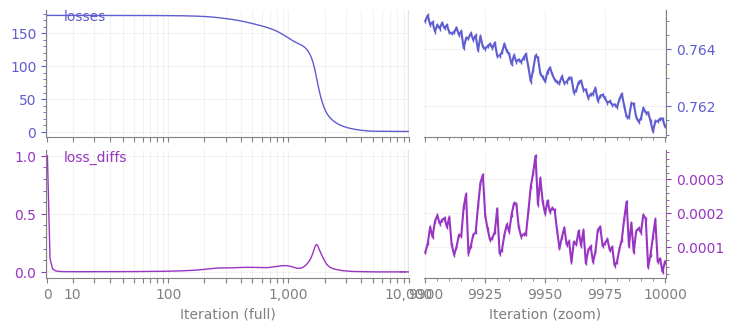

(<Figure size 800x348.22 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='Iteration (full)'>,
         <Axes: xlabel='Iteration (zoom)'>]], dtype=object))

In [99]:
optimizer_list[1][1].plot()

In [100]:
optimizer_list[1][0]

HyperParams(alpha=0.00015578674098341342, beta_1=0.18659011623469077, beta_2=0.5342039532787134, bond_dimension=6, overlap_learning_rate=134)

In [101]:
final_scores = list()

for h, o in optimizer_list:
    mpo_opt = o.get_tn_opt()
    ml, mr = split_mpo_pair(mpo_opt)

    out = (
        overlap_loss_function(ml, mr, problem_rdm),
        unitarity_tn(ml, total_physical_dim),
        unitarity_tn(mr, total_physical_dim),
    )

    final_scores.append(out)

In [102]:
final_scores

[(Array(0.0001841+2.987424e-10j, dtype=complex64),
  Array(4.5078735, dtype=float32, weak_type=True),
  Array(6.0614014, dtype=float32, weak_type=True)),
 (Array(0.00141897-6.246234e-11j, dtype=complex64),
  Array(0.95910645, dtype=float32, weak_type=True),
  Array(0.37200928, dtype=float32, weak_type=True)),
 (Array(0.00037319+1.5161765e-10j, dtype=complex64),
  Array(1.376709, dtype=float32, weak_type=True),
  Array(1.0062256, dtype=float32, weak_type=True)),
 (Array(0.00233438+5.1508503e-10j, dtype=complex64),
  Array(7.878296, dtype=float32, weak_type=True),
  Array(7.654175, dtype=float32, weak_type=True)),
 (Array(1.4890374e-07+5.6579567e-12j, dtype=complex64),
  Array(1.4644775, dtype=float32, weak_type=True),
  Array(1.5575562, dtype=float32, weak_type=True)),
 (Array(4.8023987e-05-1.7593904e-11j, dtype=complex64),
  Array(1.7425537, dtype=float32, weak_type=True),
  Array(1.7716675, dtype=float32, weak_type=True)),
 (Array(0.00320639-9.398375e-11j, dtype=complex64),
  Array(1.

Some good solutions here! Try different optimization schemes now.

So process is _very_ sensitive to number of sites. But we knew this already...

## 6 - 6 sites - CADAM

In [103]:
num_iterations = int(1e4) 
num_seeds = 10

hyperparameter_dists_dict = {
    'alpha': scipy.stats.loguniform(1e-4, 1e-2),
    'beta_1': scipy.stats.uniform(0.1, 0.5),
    'beta_2': scipy.stats.uniform(0.1, 0.5),
    'bond_dimension': scipy.stats.randint(4, 8),
    'overlap_learning_rate': scipy.stats.randint(50, 500)
}

In [104]:
HyperParams = namedtuple('HyperParams', hyperparameter_dists_dict)

In [105]:
left_most_symmetry_site=60
num_symmetry_sites=80
num_boundary_sites=6

In [106]:
optimizers = dict()

for _ in range(num_seeds):
    hyperparams ={k: v.rvs() for k, v in hyperparameter_dists_dict.items()}

    mpo = initialize_mpo(
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites,
        hyperparams['bond_dimension']
    )

    optmzr = qtn.optimize.TNOptimizer(
        mpo,                                # our initial input, the tensors of which to optimize
        loss_fn=overall_loss_function,
        loss_kwargs={
            'rdm_tn': problem_rdm,
            'total_physical_dimension': total_physical_dim,
            'unitary_cost_coefficient': 1,
            'overlap_cost_coefficient': hyperparams['overlap_learning_rate']
        },
        autodiff_backend='jax',      # {'jax', 'tensorflow', 'autograd'}
        optimizer='cadam',               # supplied to scipy.minimize
    )

    optmzr.optimize(
        num_iterations,
        learning_rate=hyperparams['alpha'],
        beta1=hyperparams['beta_1'],
        beta2=hyperparams['beta_2']
    )

    optimizers[HyperParams(**hyperparams)] = optmzr

  0%|                                                                                                                                                                             | 0/10000 [00:00<?, ?it/s]/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from complex64 to complex128.
  warnings.warn(
+1.724752426147 [best: +1.724336147308] : : 10001it [00:40, 246.28it/s]                                                                                                                                     
+1.839426755905 [best: +0.940191984177] : : 10001it [00:49, 200.80it/s]                                                                                 

In [107]:
optimizer_list = [
    (k, v) for k, v in optimizers.items()
]

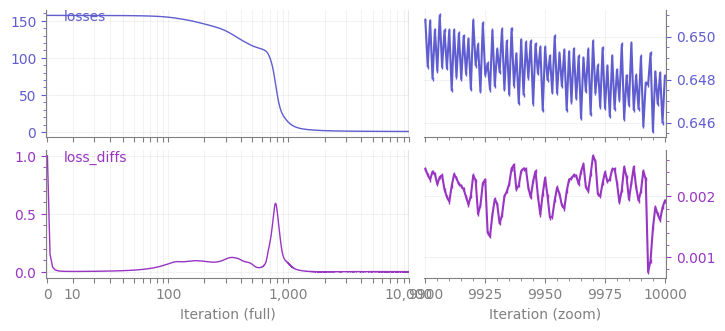

(<Figure size 800x348.22 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='Iteration (full)'>,
         <Axes: xlabel='Iteration (zoom)'>]], dtype=object))

In [108]:
optimizer_list[7][1].plot()

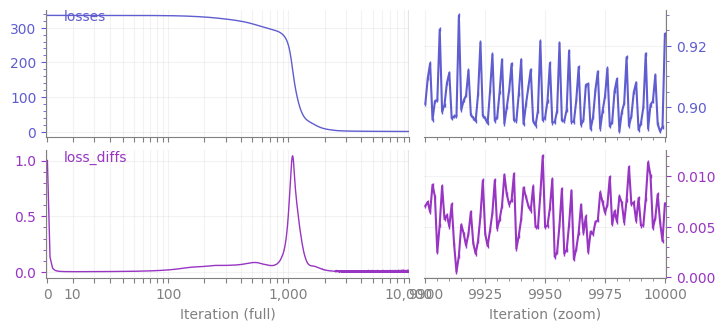

(<Figure size 800x348.22 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='Iteration (full)'>,
         <Axes: xlabel='Iteration (zoom)'>]], dtype=object))

In [109]:
optimizer_list[-1][1].plot()

In [110]:
final_scores = list()

for h, o in optimizer_list:
    mpo_opt = o.get_tn_opt()
    ml, mr = split_mpo_pair(mpo_opt)

    out = (
        overlap_loss_function(ml, mr, problem_rdm),
        unitarity_tn(ml, total_physical_dim),
        unitarity_tn(mr, total_physical_dim),
    )

    final_scores.append(out)

In [111]:
final_scores

[(Array(0.00017018+6.624835e-12j, dtype=complex64),
  Array(2.331726, dtype=float32, weak_type=True),
  Array(2.3499146, dtype=float32, weak_type=True)),
 (Array(0.00439331-5.3805976e-10j, dtype=complex64),
  Array(1.4209595, dtype=float32, weak_type=True),
  Array(0.8159485, dtype=float32, weak_type=True)),
 (Array(0.00022291-1.6208283e-11j, dtype=complex64),
  Array(1.4742432, dtype=float32, weak_type=True),
  Array(1.8571777, dtype=float32, weak_type=True)),
 (Array(0.0003108-1.4840592e-11j, dtype=complex64),
  Array(2.288086, dtype=float32, weak_type=True),
  Array(2.0393066, dtype=float32, weak_type=True)),
 (Array(0.00590953+5.131269e-12j, dtype=complex64),
  Array(0.3355713, dtype=float32, weak_type=True),
  Array(0.39898682, dtype=float32, weak_type=True)),
 (Array(0.0005087+1.942458e-11j, dtype=complex64),
  Array(0.84313965, dtype=float32, weak_type=True),
  Array(0.86138916, dtype=float32, weak_type=True)),
 (Array(0.00057157-2.448204e-11j, dtype=complex64),
  Array(1.390380

## 7 - 6 sites - RMSProp

In [112]:
num_iterations = int(1e4) 
num_seeds = 10

hyperparameter_dists_dict = {
    'learning_rate': scipy.stats.loguniform(1e-4, 1e-2),
    'gamma': scipy.stats.uniform(0.1, 0.5),
    'bond_dimension': scipy.stats.randint(4, 8),
    'overlap_learning_rate': scipy.stats.randint(50, 500)
}

In [113]:
HyperParams = namedtuple('HyperParams', hyperparameter_dists_dict)

In [114]:
left_most_symmetry_site=60
num_symmetry_sites=80
num_boundary_sites=6

In [117]:
optimizers = dict()

for _ in range(num_seeds):
    hyperparams ={k: v.rvs() for k, v in hyperparameter_dists_dict.items()}

    mpo = initialize_mpo(
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites,
        hyperparams['bond_dimension']
    )

    optmzr = qtn.optimize.TNOptimizer(
        mpo,                                # our initial input, the tensors of which to optimize
        loss_fn=overall_loss_function,
        loss_kwargs={
            'rdm_tn': problem_rdm,
            'total_physical_dimension': total_physical_dim,
            'unitary_cost_coefficient': 1,
            'overlap_cost_coefficient': hyperparams['overlap_learning_rate']
        },
        autodiff_backend='jax',      # {'jax', 'tensorflow', 'autograd'}
        optimizer='rmsprop',               # supplied to scipy.minimize
    )

    optmzr.optimize(
        num_iterations,
        learning_rate=hyperparams['learning_rate'],
        gamma=hyperparams['gamma']
    )

    optimizers[HyperParams(**hyperparams)] = optmzr

+2.883308410645 [best: +2.882722377777] : : 10001it [00:30, 323.30it/s]                                                                                                                                     
+1.951399803162 [best: +1.951399803162] : : 10001it [00:28, 347.38it/s]                                                                                                                                     
+1.815037131310 [best: +1.804419517517] : : 10001it [00:48, 206.38it/s]                                                                                                                                     
+3.633390903473 [best: +3.632665872574] : : 10001it [00:22, 436.38it/s]                                                                                                                                     
+13.707322120667 [best: +11.969124794006] : : 10001it [00:22, 441.42it/s]                                                                                                           

In [118]:
optimizer_list = [
    (k, v) for k, v in optimizers.items()
]

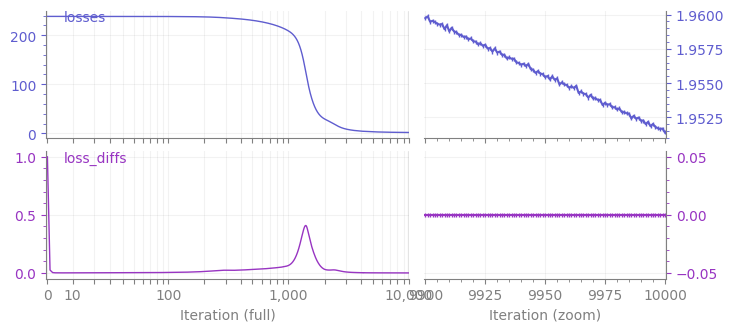

(<Figure size 800x348.22 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='Iteration (full)'>,
         <Axes: xlabel='Iteration (zoom)'>]], dtype=object))

In [119]:
optimizer_list[1][1].plot()

In [120]:
final_scores = list()

for h, o in optimizer_list:
    mpo_opt = o.get_tn_opt()
    ml, mr = split_mpo_pair(mpo_opt)

    out = (
        overlap_loss_function(ml, mr, problem_rdm),
        unitarity_tn(ml, total_physical_dim),
        unitarity_tn(mr, total_physical_dim),
    )

    final_scores.append(out)

In [121]:
final_scores

[(Array(4.785066e-05-2.2519575e-12j, dtype=complex64),
  Array(6.8703003, dtype=float32, weak_type=True),
  Array(3.2319946, dtype=float32, weak_type=True)),
 (Array(0.00167785+2.3228379e-10j, dtype=complex64),
  Array(2.317505, dtype=float32, weak_type=True),
  Array(2.2502441, dtype=float32, weak_type=True)),
 (Array(6.012957e-05-7.983939e-11j, dtype=complex64),
  Array(2.6537476, dtype=float32, weak_type=True),
  Array(2.552246, dtype=float32, weak_type=True)),
 (Array(0.00048426+2.9577507e-11j, dtype=complex64),
  Array(6.6636353, dtype=float32, weak_type=True),
  Array(6.363159, dtype=float32, weak_type=True)),
 (Array(0.02190942-1.2897162e-09j, dtype=complex64),
  Array(6.474182, dtype=float32, weak_type=True),
  Array(4.306671, dtype=float32, weak_type=True)),
 (Array(0.01150531-8.5616547e-10j, dtype=complex64),
  Array(3.5093079, dtype=float32, weak_type=True),
  Array(3.243866, dtype=float32, weak_type=True)),
 (Array(0.00297571-8.092223e-10j, dtype=complex64),
  Array(1.36248

Some good solutions here! Try different optimization schemes now.

So process is _very_ sensitive to number of sites. But we knew this already...

## 8 - 6 sites - ADABelief

In [122]:
num_iterations = int(1e4) 
num_seeds = 10

hyperparameter_dists_dict = {
    'alpha': scipy.stats.loguniform(1e-4, 1e-2),
    'beta_1': scipy.stats.uniform(0.1, 0.5),
    'beta_2': scipy.stats.uniform(0.1, 0.5),
    'bond_dimension': scipy.stats.randint(4, 8),
    'overlap_learning_rate': scipy.stats.randint(50, 500)
}

In [123]:
HyperParams = namedtuple('HyperParams', hyperparameter_dists_dict)

In [124]:
left_most_symmetry_site=60
num_symmetry_sites=80
num_boundary_sites=6

In [125]:
optimizers = dict()

for _ in range(num_seeds):
    hyperparams ={k: v.rvs() for k, v in hyperparameter_dists_dict.items()}

    mpo = initialize_mpo(
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites,
        hyperparams['bond_dimension']
    )

    optmzr = qtn.optimize.TNOptimizer(
        mpo,                                # our initial input, the tensors of which to optimize
        loss_fn=overall_loss_function,
        loss_kwargs={
            'rdm_tn': problem_rdm,
            'total_physical_dimension': total_physical_dim,
            'unitary_cost_coefficient': 1,
            'overlap_cost_coefficient': hyperparams['overlap_learning_rate']
        },
        autodiff_backend='jax',      # {'jax', 'tensorflow', 'autograd'}
        optimizer='adabelief',               # supplied to scipy.minimize
    )

    optmzr.optimize(
        num_iterations,
        learning_rate=hyperparams['alpha'],
        beta1=hyperparams['beta_1'],
        beta2=hyperparams['beta_2']
    )

    optimizers[HyperParams(**hyperparams)] = optmzr

  0%|                                                                                                                                                                             | 0/10000 [00:00<?, ?it/s]/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from complex64 to complex128.
  warnings.warn(
+0.785195231438 [best: +0.753531455994] : : 10001it [00:35, 282.76it/s]                                                                                                                                     
+3.741279602051 [best: +2.912903785706] : : 10001it [00:43, 230.55it/s]                                                                                 

In [98]:
optimizer_list = [
    (k, v) for k, v in optimizers.items()
]

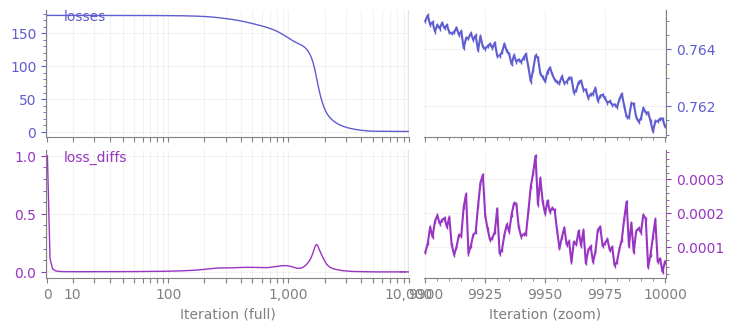

(<Figure size 800x348.22 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='Iteration (full)'>,
         <Axes: xlabel='Iteration (zoom)'>]], dtype=object))

In [99]:
optimizer_list[1][1].plot()

In [100]:
optimizer_list[1][0]

HyperParams(alpha=0.00015578674098341342, beta_1=0.18659011623469077, beta_2=0.5342039532787134, bond_dimension=6, overlap_learning_rate=134)

In [101]:
final_scores = list()

for h, o in optimizer_list:
    mpo_opt = o.get_tn_opt()
    ml, mr = split_mpo_pair(mpo_opt)

    out = (
        overlap_loss_function(ml, mr, problem_rdm),
        unitarity_tn(ml, total_physical_dim),
        unitarity_tn(mr, total_physical_dim),
    )

    final_scores.append(out)

In [102]:
final_scores

[(Array(0.0001841+2.987424e-10j, dtype=complex64),
  Array(4.5078735, dtype=float32, weak_type=True),
  Array(6.0614014, dtype=float32, weak_type=True)),
 (Array(0.00141897-6.246234e-11j, dtype=complex64),
  Array(0.95910645, dtype=float32, weak_type=True),
  Array(0.37200928, dtype=float32, weak_type=True)),
 (Array(0.00037319+1.5161765e-10j, dtype=complex64),
  Array(1.376709, dtype=float32, weak_type=True),
  Array(1.0062256, dtype=float32, weak_type=True)),
 (Array(0.00233438+5.1508503e-10j, dtype=complex64),
  Array(7.878296, dtype=float32, weak_type=True),
  Array(7.654175, dtype=float32, weak_type=True)),
 (Array(1.4890374e-07+5.6579567e-12j, dtype=complex64),
  Array(1.4644775, dtype=float32, weak_type=True),
  Array(1.5575562, dtype=float32, weak_type=True)),
 (Array(4.8023987e-05-1.7593904e-11j, dtype=complex64),
  Array(1.7425537, dtype=float32, weak_type=True),
  Array(1.7716675, dtype=float32, weak_type=True)),
 (Array(0.00320639-9.398375e-11j, dtype=complex64),
  Array(1.

## 9 - 6 sites - L-BFGS-B

In [126]:
num_iterations = int(1e4) 
num_seeds = 10

hyperparameter_dists_dict = {
    'bond_dimension': scipy.stats.randint(4, 8),
    'overlap_learning_rate': scipy.stats.randint(50, 500)
}

In [127]:
HyperParams = namedtuple('HyperParams', hyperparameter_dists_dict)

In [128]:
left_most_symmetry_site=60
num_symmetry_sites=80
num_boundary_sites=6

In [129]:
optimizers = dict()

for _ in range(num_seeds):
    hyperparams ={k: v.rvs() for k, v in hyperparameter_dists_dict.items()}

    mpo = initialize_mpo(
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites,
        hyperparams['bond_dimension']
    )

    optmzr = qtn.optimize.TNOptimizer(
        mpo,                                # our initial input, the tensors of which to optimize
        loss_fn=overall_loss_function,
        loss_kwargs={
            'rdm_tn': problem_rdm,
            'total_physical_dimension': total_physical_dim,
            'unitary_cost_coefficient': 1,
            'overlap_cost_coefficient': hyperparams['overlap_learning_rate']
        },
        autodiff_backend='jax',      # {'jax', 'tensorflow', 'autograd'}
        optimizer='L-BFGS-B',               # supplied to scipy.minimize
    )

    optmzr.optimize(
        num_iterations,
    )

    optimizers[HyperParams(**hyperparams)] = optmzr

+1.284460663795 [best: +1.284460663795] :  15%|█████████████████▋                                                                                                     | 1490/10000 [00:04<00:24, 347.91it/s]


In [130]:
optimizer_list = [
    (k, v) for k, v in optimizers.items()
]

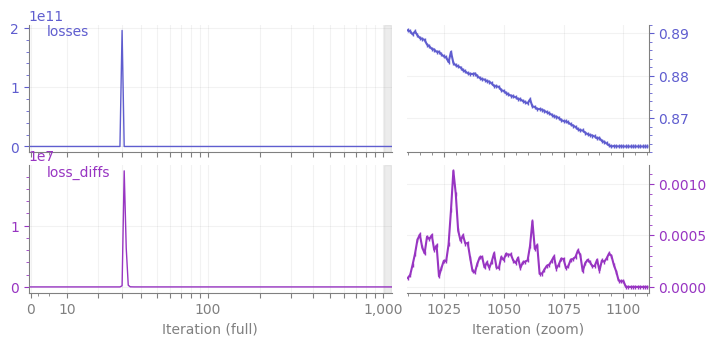

(<Figure size 800x348.22 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='Iteration (full)'>,
         <Axes: xlabel='Iteration (zoom)'>]], dtype=object))

In [131]:
optimizer_list[1][1].plot()

In [133]:
final_scores = list()

for h, o in optimizer_list:
    mpo_opt = o.get_tn_opt()
    ml, mr = split_mpo_pair(mpo_opt)

    out = (
        overlap_loss_function(ml, mr, problem_rdm),
        unitarity_tn(ml, total_physical_dim),
        unitarity_tn(mr, total_physical_dim),
    )

    final_scores.append(out)

In [134]:
final_scores

[(Array(0.00545003+4.8365567e-10j, dtype=complex64),
  Array(0.7529297, dtype=float32, weak_type=True),
  Array(1.3076172, dtype=float32, weak_type=True)),
 (Array(0.00011455-1.3894959e-11j, dtype=complex64),
  Array(1.1528931, dtype=float32, weak_type=True),
  Array(0.805542, dtype=float32, weak_type=True)),
 (Array(0.00022687+1.2122624e-10j, dtype=complex64),
  Array(1.8661499, dtype=float32, weak_type=True),
  Array(1.6523438, dtype=float32, weak_type=True)),
 (Array(0.004937-1.2695345e-10j, dtype=complex64),
  Array(0.9071655, dtype=float32, weak_type=True),
  Array(0.9797363, dtype=float32, weak_type=True)),
 (Array(0.00216128+1.7534195e-10j, dtype=complex64),
  Array(0.64172363, dtype=float32, weak_type=True),
  Array(1.1722412, dtype=float32, weak_type=True)),
 (Array(0.00016974-8.165115e-12j, dtype=complex64),
  Array(1.7104492, dtype=float32, weak_type=True),
  Array(0.9963989, dtype=float32, weak_type=True)),
 (Array(0.00160754+1.739984e-10j, dtype=complex64),
  Array(0.67785

## 10 - 8 sites - L-BFGS-B

In [135]:
problem_rdm = generate_problem_rdm(
    q1,
    symmetry_site_pairs,
    60,
    80,
    8
)

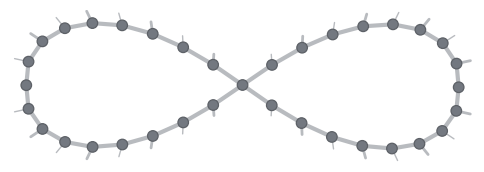

In [136]:
problem_rdm.draw()

In [137]:
total_physical_dim = 2**(3*4)

In [138]:
total_physical_dim

4096

In [139]:
num_iterations = int(1e4) 
num_seeds = 10

hyperparameter_dists_dict = {
    'alpha': scipy.stats.loguniform(1e-4, 1e-2),
    'beta_1': scipy.stats.uniform(0.1, 0.5),
    'beta_2': scipy.stats.uniform(0.1, 0.5),
    'bond_dimension': scipy.stats.randint(4, 8),
    'overlap_learning_rate': scipy.stats.randint(50, 500)
}

In [140]:
HyperParams = namedtuple('HyperParams', hyperparameter_dists_dict)

In [141]:
left_most_symmetry_site=60
num_symmetry_sites=80
num_boundary_sites=8

In [142]:
num_iterations = int(1e4) 
num_seeds = 10

hyperparameter_dists_dict = {
    'bond_dimension': scipy.stats.randint(4, 8),
    'overlap_learning_rate': scipy.stats.randint(50, 500)
}

In [143]:
HyperParams = namedtuple('HyperParams', hyperparameter_dists_dict)

In [144]:
left_most_symmetry_site=60
num_symmetry_sites=80
num_boundary_sites=8

In [145]:
optimizers = dict()

for _ in range(num_seeds):
    hyperparams ={k: v.rvs() for k, v in hyperparameter_dists_dict.items()}

    mpo = initialize_mpo(
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites,
        hyperparams['bond_dimension']
    )

    optmzr = qtn.optimize.TNOptimizer(
        mpo,                                # our initial input, the tensors of which to optimize
        loss_fn=overall_loss_function,
        loss_kwargs={
            'rdm_tn': problem_rdm,
            'total_physical_dimension': total_physical_dim,
            'unitary_cost_coefficient': 1,
            'overlap_cost_coefficient': hyperparams['overlap_learning_rate']
        },
        autodiff_backend='jax',      # {'jax', 'tensorflow', 'autograd'}
        optimizer='L-BFGS-B',               # supplied to scipy.minimize
    )

    optmzr.optimize(
        num_iterations,
    )

    optimizers[HyperParams(**hyperparams)] = optmzr

  0%|                                                                                                                                                                             | 0/10000 [00:00<?, ?it/s]/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from complex64 to complex128.
  warnings.warn(
+243.068862915039 [best: +243.068862915039] :   3%|███▎                                                                                                                | 282/10000 [00:01<01:07, 143.44it/s]


In [147]:
optimizer_list = [
    (k, v) for k, v in optimizers.items()
]

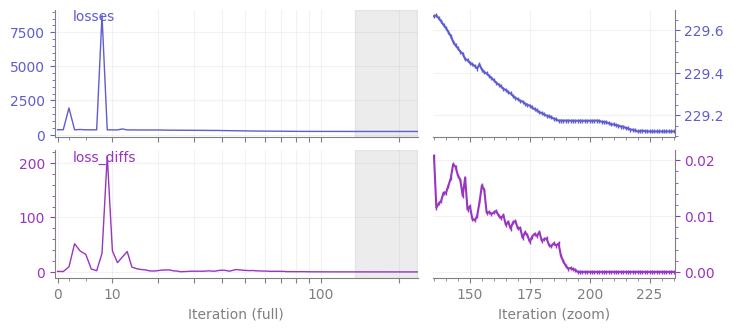

(<Figure size 800x348.22 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='Iteration (full)'>,
         <Axes: xlabel='Iteration (zoom)'>]], dtype=object))

In [148]:
optimizer_list[1][1].plot()

In [149]:
final_scores = list()

for h, o in optimizer_list:
    mpo_opt = o.get_tn_opt()
    ml, mr = split_mpo_pair(mpo_opt)

    out = (
        overlap_loss_function(ml, mr, problem_rdm),
        unitarity_tn(ml, total_physical_dim),
        unitarity_tn(mr, total_physical_dim),
    )

    final_scores.append(out)

In [150]:
final_scores

[(Array(0.9999697+1.5616572e-13j, dtype=complex64),
  Array(0.11132812, dtype=float32, weak_type=True),
  Array(0.11865234, dtype=float32, weak_type=True)),
 (Array(0.9999906-4.227562e-14j, dtype=complex64),
  Array(0.07080078, dtype=float32, weak_type=True),
  Array(0.19604492, dtype=float32, weak_type=True)),
 (Array(0.9999565-3.7828642e-16j, dtype=complex64),
  Array(0.6621094, dtype=float32, weak_type=True),
  Array(0.13574219, dtype=float32, weak_type=True)),
 (Array(0.9999975+1.7869638e-15j, dtype=complex64),
  Array(0.10644531, dtype=float32, weak_type=True),
  Array(0.1616211, dtype=float32, weak_type=True)),
 (Array(0.9998851-7.225706e-13j, dtype=complex64),
  Array(0.56591797, dtype=float32, weak_type=True),
  Array(0.3359375, dtype=float32, weak_type=True)),
 (Array(0.9999949-5.095945e-16j, dtype=complex64),
  Array(0.19970703, dtype=float32, weak_type=True),
  Array(0.07788086, dtype=float32, weak_type=True)),
 (Array(0.99998534-1.4751995e-14j, dtype=complex64),
  Array(0.1

## 11 - 8 sites - CADAM

In [151]:
num_iterations = int(1e4) 
num_seeds = 10

hyperparameter_dists_dict = {
    'alpha': scipy.stats.loguniform(1e-4, 1e-2),
    'beta_1': scipy.stats.uniform(0.1, 0.5),
    'beta_2': scipy.stats.uniform(0.1, 0.5),
    'bond_dimension': scipy.stats.randint(4, 8),
    'overlap_learning_rate': scipy.stats.randint(50, 500)
}

In [152]:
HyperParams = namedtuple('HyperParams', hyperparameter_dists_dict)

In [153]:
left_most_symmetry_site=60
num_symmetry_sites=80
num_boundary_sites=8

In [154]:
optimizers = dict()

for _ in range(num_seeds):
    hyperparams ={k: v.rvs() for k, v in hyperparameter_dists_dict.items()}

    mpo = initialize_mpo(
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites,
        hyperparams['bond_dimension']
    )

    optmzr = qtn.optimize.TNOptimizer(
        mpo,                                # our initial input, the tensors of which to optimize
        loss_fn=overall_loss_function,
        loss_kwargs={
            'rdm_tn': problem_rdm,
            'total_physical_dimension': total_physical_dim,
            'unitary_cost_coefficient': 1,
            'overlap_cost_coefficient': hyperparams['overlap_learning_rate']
        },
        autodiff_backend='jax',      # {'jax', 'tensorflow', 'autograd'}
        optimizer='cadam',               # supplied to scipy.minimize
    )

    optmzr.optimize(
        num_iterations,
        learning_rate=hyperparams['alpha'],
        beta1=hyperparams['beta_1'],
        beta2=hyperparams['beta_2']
    )

    optimizers[HyperParams(**hyperparams)] = optmzr

  0%|                                                                                                                                                                             | 0/10000 [00:00<?, ?it/s]/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from complex64 to complex128.
  warnings.warn(
+119.863952636719 [best: +119.785896301270] : : 10001it [00:53, 186.16it/s]                                                                                                                                 
+337.751647949219 [best: +330.609405517578] : : 10001it [01:17, 129.64it/s]                                                                             

In [155]:
optimizer_list = [
    (k, v) for k, v in optimizers.items()
]

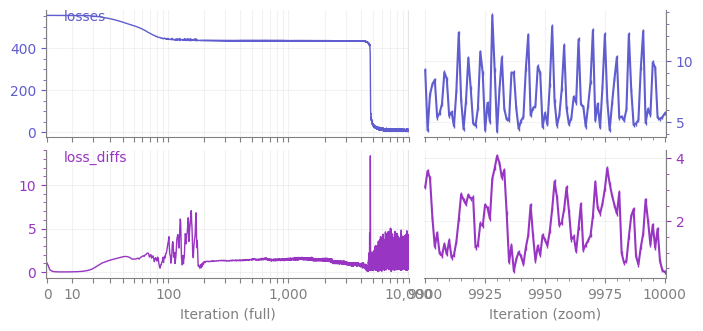

(<Figure size 800x348.22 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='Iteration (full)'>,
         <Axes: xlabel='Iteration (zoom)'>]], dtype=object))

In [156]:
optimizer_list[8][1].plot()

In [157]:
final_scores = list()

for h, o in optimizer_list:
    mpo_opt = o.get_tn_opt()
    ml, mr = split_mpo_pair(mpo_opt)

    out = (
        overlap_loss_function(ml, mr, problem_rdm),
        unitarity_tn(ml, total_physical_dim),
        unitarity_tn(mr, total_physical_dim),
    )

    final_scores.append(out)

In [158]:
final_scores

[(Array(0.99997604+1.5743364e-14j, dtype=complex64),
  Array(2.7993164, dtype=float32, weak_type=True),
  Array(2.6738281, dtype=float32, weak_type=True)),
 (Array(0.99983215-1.0847279e-12j, dtype=complex64),
  Array(86.055664, dtype=float32, weak_type=True),
  Array(88.63867, dtype=float32, weak_type=True)),
 (Array(0.9999466-1.9839519e-13j, dtype=complex64),
  Array(0.25439453, dtype=float32, weak_type=True),
  Array(0.22851562, dtype=float32, weak_type=True)),
 (Array(0.9998419-1.4656688e-13j, dtype=complex64),
  Array(220.47803, dtype=float32, weak_type=True),
  Array(426.91064, dtype=float32, weak_type=True)),
 (Array(0.9999542+1.6868402e-13j, dtype=complex64),
  Array(0.34326172, dtype=float32, weak_type=True),
  Array(0.26904297, dtype=float32, weak_type=True)),
 (Array(0.9999727+1.0065016e-14j, dtype=complex64),
  Array(0.3383789, dtype=float32, weak_type=True),
  Array(0.20263672, dtype=float32, weak_type=True)),
 (Array(0.9995362-8.8058673e-13j, dtype=complex64),
  Array(43.8

## 12 - 6 sites - CADAM - basinhopping

In [34]:
problem_rdm = generate_problem_rdm(
    q1,
    symmetry_site_pairs,
    60,
    80,
    6
)

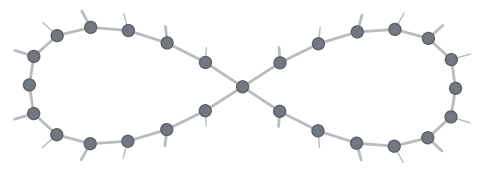

In [35]:
problem_rdm.draw()

In [37]:
total_physical_dim = 2**(3*3)

In [38]:
total_physical_dim

512

In [49]:
num_iterations = int(1e4) 
num_seeds = 5
nhop = 5

hyperparameter_dists_dict = {
    'alpha': scipy.stats.loguniform(1e-4, 1e-2),
    'beta_1': scipy.stats.uniform(0.1, 0.5),
    'beta_2': scipy.stats.uniform(0.1, 0.5),
    'bond_dimension': scipy.stats.randint(4, 8),
    'overlap_learning_rate': scipy.stats.randint(50, 500)
}

In [50]:
HyperParams = namedtuple('HyperParams', hyperparameter_dists_dict)

In [51]:
left_most_symmetry_site=60
num_symmetry_sites=80
num_boundary_sites=6

In [52]:
optimizers = dict()

for _ in range(num_seeds):
    hyperparams ={k: v.rvs() for k, v in hyperparameter_dists_dict.items()}

    mpo = initialize_mpo(
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites,
        hyperparams['bond_dimension']
    )

    optmzr = qtn.optimize.TNOptimizer(
        mpo,                                # our initial input, the tensors of which to optimize
        loss_fn=overall_loss_function,
        loss_kwargs={
            'rdm_tn': problem_rdm,
            'total_physical_dimension': total_physical_dim,
            'unitary_cost_coefficient': 1,
            'overlap_cost_coefficient': hyperparams['overlap_learning_rate']
        },
        autodiff_backend='jax',      # {'jax', 'tensorflow', 'autograd'}
        optimizer='cadam',               # supplied to scipy.minimize
    )

    optmzr.optimize_basinhopping(
        num_iterations,
        nhop,
        learning_rate=hyperparams['alpha'],
        beta1=hyperparams['beta_1'],
        beta2=hyperparams['beta_2']
    )

    optimizers[HyperParams(**hyperparams)] = optmzr

  0%|                                                                                                                                                                             | 0/50000 [00:00<?, ?it/s]/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from complex64 to complex128.
  warnings.warn(
+0.311685442924 [best: +0.061742682010] : : 60006it [05:10, 193.29it/s]                                                                                                                                     
+0.005185749382 [best: +0.000385792839] : : 60006it [05:28, 182.45it/s]                                                                                 

In [53]:
optimizer_list = [
    (k, v) for k, v in optimizers.items()
]

In [55]:
optimizer_list[0][0]

HyperParams(alpha=0.0013618795565498345, beta_1=0.384591918281723, beta_2=0.5721569641763766, bond_dimension=7, overlap_learning_rate=255)

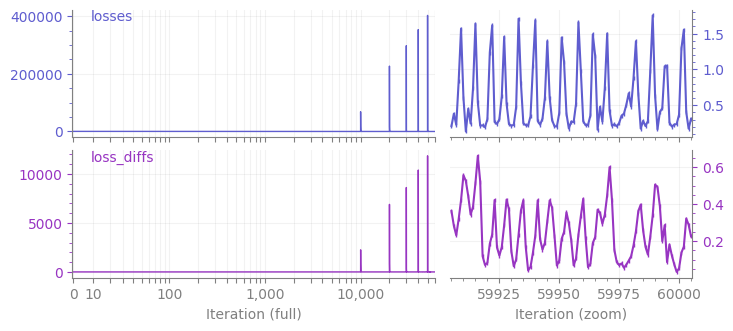

(<Figure size 800x348.22 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='Iteration (full)'>,
         <Axes: xlabel='Iteration (zoom)'>]], dtype=object))

In [54]:
optimizer_list[0][1].plot()

In [56]:
optimizer_list[1][0]

HyperParams(alpha=0.00010350879753692379, beta_1=0.5726626387592584, beta_2=0.5036044490946738, bond_dimension=5, overlap_learning_rate=395)

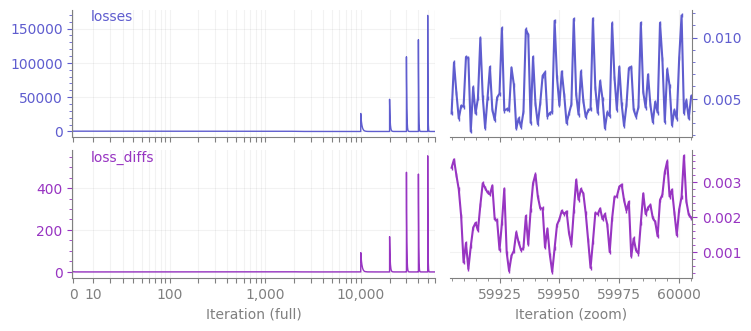

(<Figure size 800x348.22 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='Iteration (full)'>,
         <Axes: xlabel='Iteration (zoom)'>]], dtype=object))

In [57]:
optimizer_list[1][1].plot()

In [58]:
optimizer_list[2][0]

HyperParams(alpha=0.0044128847368471585, beta_1=0.5866667002805205, beta_2=0.38526213841838597, bond_dimension=6, overlap_learning_rate=245)

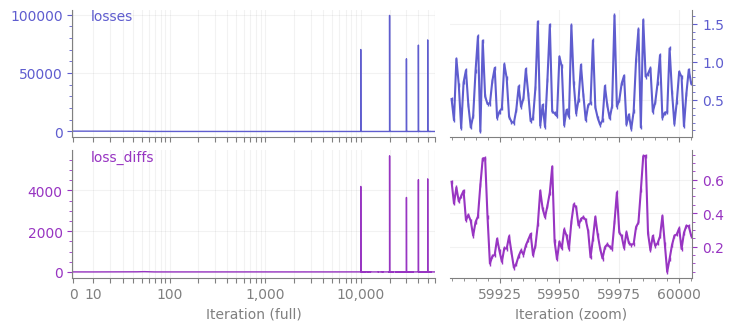

(<Figure size 800x348.22 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='Iteration (full)'>,
         <Axes: xlabel='Iteration (zoom)'>]], dtype=object))

In [59]:
optimizer_list[2][1].plot()

In [60]:
optimizer_list[3][0]

HyperParams(alpha=0.007819872753050891, beta_1=0.4775307971410325, beta_2=0.5368576302553517, bond_dimension=5, overlap_learning_rate=142)

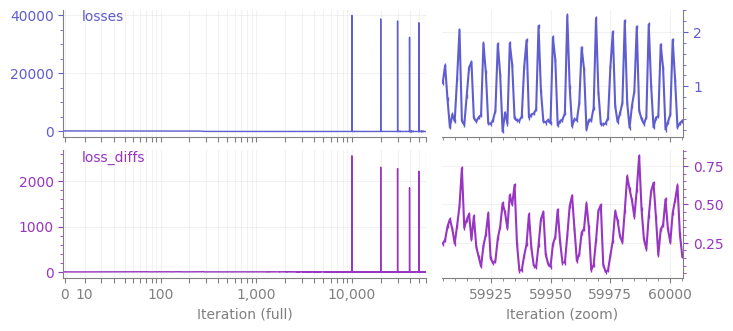

(<Figure size 800x348.22 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='Iteration (full)'>,
         <Axes: xlabel='Iteration (zoom)'>]], dtype=object))

In [61]:
optimizer_list[3][1].plot()

In [65]:
optimizer_list[4][0]

HyperParams(alpha=0.0002119447097960791, beta_1=0.15363505238922362, beta_2=0.30066737946991173, bond_dimension=7, overlap_learning_rate=351)

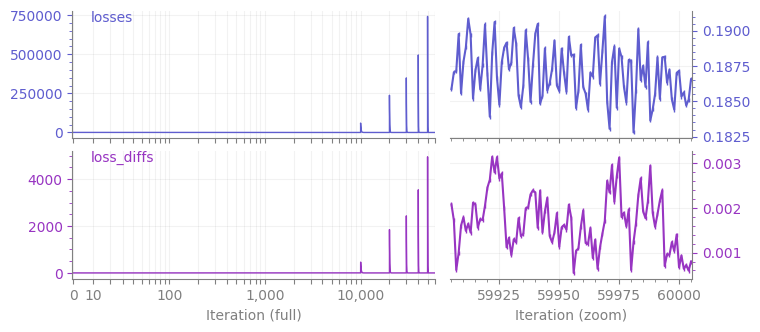

(<Figure size 800x348.22 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='Iteration (full)'>,
         <Axes: xlabel='Iteration (zoom)'>]], dtype=object))

In [66]:
optimizer_list[4][1].plot()

In [67]:
final_scores = list()

for h, o in optimizer_list:
    mpo_opt = o.get_tn_opt()
    ml, mr = split_mpo_pair(mpo_opt)

    out = (
        overlap_loss_function(ml, mr, problem_rdm),
        unitarity_tn(ml, total_physical_dim),
        unitarity_tn(mr, total_physical_dim),
    )

    final_scores.append(out)

In [68]:
final_scores

[(Array(2.2183714e-07-2.9084335e-12j, dtype=complex64),
  Array(0.09350586, dtype=float32, weak_type=True),
  Array(0.11291504, dtype=float32, weak_type=True)),
 (Array(3.5392262e-07-5.8632244e-13j, dtype=complex64),
  Array(0.00042725, dtype=float32, weak_type=True),
  Array(0.00048828, dtype=float32, weak_type=True)),
 (Array(0.00043429-5.695807e-11j, dtype=complex64),
  Array(0.4541626, dtype=float32, weak_type=True),
  Array(0.3817749, dtype=float32, weak_type=True)),
 (Array(0.00019357+9.2127285e-11j, dtype=complex64),
  Array(0.3912964, dtype=float32, weak_type=True),
  Array(0.22213745, dtype=float32, weak_type=True)),
 (Array(4.191291e-05-4.4757153e-11j, dtype=complex64),
  Array(0.05200195, dtype=float32, weak_type=True),
  Array(0.05578613, dtype=float32, weak_type=True))]

All look good.

## 13 - 6 sites - CADAM - basinhopping - bare unitarity

In [69]:
def overall_loss_function(mpo_pair, rdm_tn, total_physical_dimension,
    unitary_cost_coefficient=1, overlap_cost_coefficient=1, losses=None):
    ml, mr = split_mpo_pair(mpo_pair)

    o_loss = overlap_loss_function(ml, mr, rdm_tn)
    ul_loss = unitarity_tn(ml, total_physical_dimension)
    ur_loss = unitarity_tn(mr, total_physical_dimension)

    out = (
        unitary_cost_coefficient*(ul_loss+ur_loss)
        + overlap_cost_coefficient*o_loss
    )

    out = jnp.real(out)

    if losses is not None:
        losses.append((o_loss, ul_loss, ur_loss))
    return out

In [72]:
num_iterations = int(1e4) 
num_seeds = 2
nhop = 5

hyperparameter_dists_dict = {
    'alpha': scipy.stats.loguniform(1e-4, 1e-2),
    'beta_1': scipy.stats.uniform(0.1, 0.5),
    'beta_2': scipy.stats.uniform(0.1, 0.5),
    'bond_dimension': scipy.stats.randint(4, 8),
    'overlap_learning_rate': scipy.stats.randint(50, 500)
}

In [73]:
HyperParams = namedtuple('HyperParams', hyperparameter_dists_dict)

In [74]:
left_most_symmetry_site=60
num_symmetry_sites=80
num_boundary_sites=6

In [75]:
optimizers = dict()

for _ in range(num_seeds):
    hyperparams ={k: v.rvs() for k, v in hyperparameter_dists_dict.items()}

    mpo = initialize_mpo(
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites,
        hyperparams['bond_dimension']
    )

    optmzr = qtn.optimize.TNOptimizer(
        mpo,                                # our initial input, the tensors of which to optimize
        loss_fn=overall_loss_function,
        loss_kwargs={
            'rdm_tn': problem_rdm,
            'total_physical_dimension': total_physical_dim,
            'unitary_cost_coefficient': 1,
            'overlap_cost_coefficient': hyperparams['overlap_learning_rate']
        },
        autodiff_backend='jax',      # {'jax', 'tensorflow', 'autograd'}
        optimizer='cadam',               # supplied to scipy.minimize
    )

    optmzr.optimize_basinhopping(
        num_iterations,
        nhop,
        learning_rate=hyperparams['alpha'],
        beta1=hyperparams['beta_1'],
        beta2=hyperparams['beta_2']
    )

    optimizers[HyperParams(**hyperparams)] = optmzr

  0%|                                                                                                                                                                             | 0/50000 [00:00<?, ?it/s]/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from complex64 to complex128.
  warnings.warn(
+2.900564432144 [best: +2.140836715698] : : 60006it [04:16, 234.12it/s]                                                                                                                                     
+4.717047214508 [best: +4.715735435486] : : 60006it [01:55, 520.08it/s]                                                                                 

In [76]:
optimizer_list = [
    (k, v) for k, v in optimizers.items()
]

In [77]:
optimizer_list[0][0]

HyperParams(alpha=0.005773561616987446, beta_1=0.21258169119666911, beta_2=0.22087993211752907, bond_dimension=7, overlap_learning_rate=455)

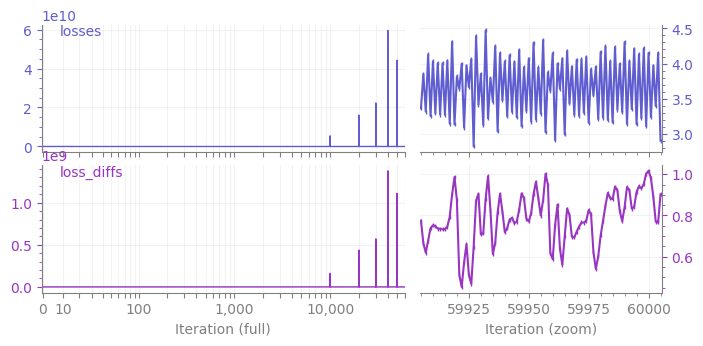

(<Figure size 800x348.22 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='Iteration (full)'>,
         <Axes: xlabel='Iteration (zoom)'>]], dtype=object))

In [78]:
optimizer_list[0][1].plot()

In [79]:
optimizer_list[1][0]

HyperParams(alpha=0.00012559387827312547, beta_1=0.25598445955971216, beta_2=0.4732884188956268, bond_dimension=4, overlap_learning_rate=60)

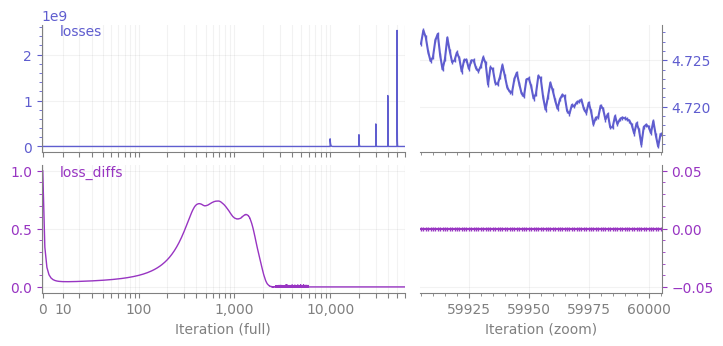

(<Figure size 800x348.22 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='Iteration (full)'>,
         <Axes: xlabel='Iteration (zoom)'>]], dtype=object))

In [80]:
optimizer_list[1][1].plot()

In [81]:
final_scores = list()

for h, o in optimizer_list:
    mpo_opt = o.get_tn_opt()
    ml, mr = split_mpo_pair(mpo_opt)

    out = (
        overlap_loss_function(ml, mr, problem_rdm),
        unitarity_tn(ml, total_physical_dim),
        unitarity_tn(mr, total_physical_dim),
    )

    final_scores.append(out)

In [82]:
final_scores

[(Array(0.00137652-1.0236991e-10j, dtype=complex64),
  Array(0.93566895, dtype=float32, weak_type=True),
  Array(1.338623, dtype=float32, weak_type=True)),
 (Array(0.07032653+1.0089877e-09j, dtype=complex64),
  Array(0.2972412, dtype=float32, weak_type=True),
  Array(0.19946289, dtype=float32, weak_type=True))]

Looks even better without actually.

## 14 - 6 sites - CADAM - basinhopping - bare overlap

In [83]:
def overall_loss_function(mpo_pair, rdm_tn, total_physical_dimension,
    unitary_cost_coefficient=1, overlap_cost_coefficient=1, losses=None):
    ml, mr = split_mpo_pair(mpo_pair)

    o_loss = overlap_loss_function(ml, mr, rdm_tn, epsilon=0)
    ul_loss = unitarity_tn(ml, total_physical_dimension)
    ur_loss = unitarity_tn(mr, total_physical_dimension)

    out = (
        unitary_cost_coefficient*(ul_loss+ur_loss)
        + overlap_cost_coefficient*o_loss
    )

    out = jnp.real(out)

    if losses is not None:
        losses.append((o_loss, ul_loss, ur_loss))
    return out

In [88]:
num_iterations = int(1e4) 
num_seeds = 4
nhop = 5

hyperparameter_dists_dict = {
    'alpha': scipy.stats.loguniform(1e-4, 1e-2),
    'beta_1': scipy.stats.uniform(0.1, 0.5),
    'beta_2': scipy.stats.uniform(0.1, 0.5),
    'bond_dimension': scipy.stats.randint(4, 8),
    'overlap_learning_rate': scipy.stats.randint(50, 500)
}

In [89]:
HyperParams = namedtuple('HyperParams', hyperparameter_dists_dict)

In [90]:
left_most_symmetry_site=60
num_symmetry_sites=80
num_boundary_sites=6

In [91]:
optimizers = dict()

for _ in range(num_seeds):
    hyperparams ={k: v.rvs() for k, v in hyperparameter_dists_dict.items()}

    mpo = initialize_mpo(
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites,
        hyperparams['bond_dimension']
    )

    optmzr = qtn.optimize.TNOptimizer(
        mpo,                                # our initial input, the tensors of which to optimize
        loss_fn=overall_loss_function,
        loss_kwargs={
            'rdm_tn': problem_rdm,
            'total_physical_dimension': total_physical_dim,
            'unitary_cost_coefficient': 1,
            'overlap_cost_coefficient': hyperparams['overlap_learning_rate']
        },
        autodiff_backend='jax',      # {'jax', 'tensorflow', 'autograd'}
        optimizer='cadam',               # supplied to scipy.minimize
    )

    optmzr.optimize_basinhopping(
        num_iterations,
        nhop,
        learning_rate=hyperparams['alpha'],
        beta1=hyperparams['beta_1'],
        beta2=hyperparams['beta_2']
    )

    optimizers[HyperParams(**hyperparams)] = optmzr

+0.599653720856 [best: +0.464452832937] : : 60006it [02:25, 411.38it/s]                                                                                                                                     
+0.268117964268 [best: +0.101705908775] : : 60006it [40:18, 24.81it/s]                                                                                                                                      
+3.499947071075 [best: +1.196147918701] : : 60006it [02:30, 399.62it/s]                                                                                                                                     
+13.582140922546 [best: +10.838953971863] : : 60006it [04:47, 208.71it/s]                                                                                                                                   


In [92]:
optimizer_list = [
    (k, v) for k, v in optimizers.items()
]

In [93]:
optimizer_list[0][0]

HyperParams(alpha=0.0011212361363332572, beta_1=0.1727262025032639, beta_2=0.29922165001586554, bond_dimension=4, overlap_learning_rate=112)

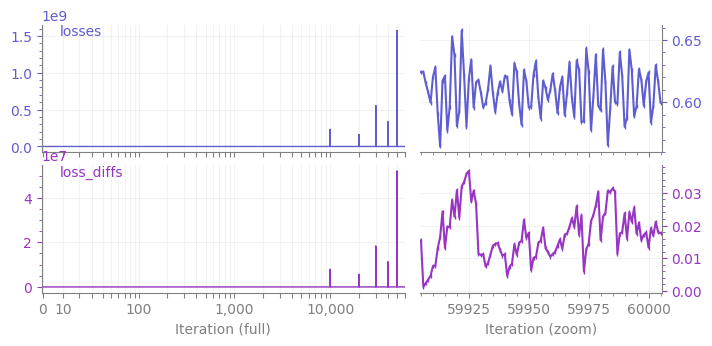

(<Figure size 800x348.22 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='Iteration (full)'>,
         <Axes: xlabel='Iteration (zoom)'>]], dtype=object))

In [94]:
optimizer_list[0][1].plot()

In [95]:
optimizer_list[1][0]

HyperParams(alpha=0.0018316319565722173, beta_1=0.4114087929077548, beta_2=0.40905475907464417, bond_dimension=4, overlap_learning_rate=474)

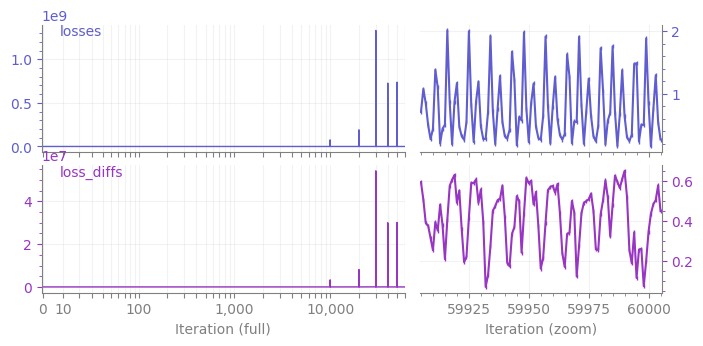

(<Figure size 800x348.22 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='Iteration (full)'>,
         <Axes: xlabel='Iteration (zoom)'>]], dtype=object))

In [96]:
optimizer_list[1][1].plot()

In [97]:
optimizer_list[2][0]

HyperParams(alpha=0.0036652819473570355, beta_1=0.2850266813715968, beta_2=0.1340168472830491, bond_dimension=5, overlap_learning_rate=309)

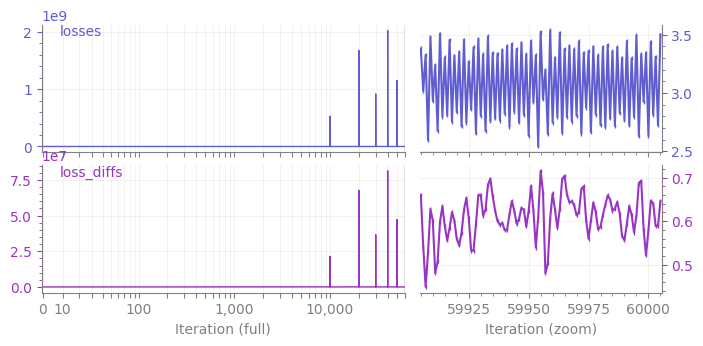

(<Figure size 800x348.22 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='Iteration (full)'>,
         <Axes: xlabel='Iteration (zoom)'>]], dtype=object))

In [98]:
optimizer_list[2][1].plot()

In [100]:
optimizer_list[3][0]

HyperParams(alpha=0.004999800320792636, beta_1=0.2586864285726591, beta_2=0.2850457474023087, bond_dimension=4, overlap_learning_rate=301)

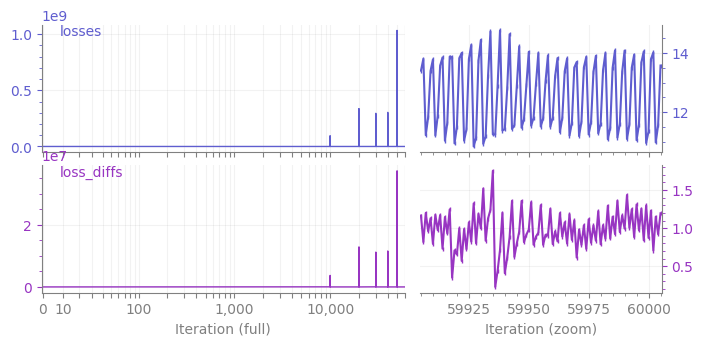

(<Figure size 800x348.22 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='Iteration (full)'>,
         <Axes: xlabel='Iteration (zoom)'>]], dtype=object))

In [101]:
optimizer_list[3][1].plot()

In [102]:
final_scores = list()

for h, o in optimizer_list:
    mpo_opt = o.get_tn_opt()
    ml, mr = split_mpo_pair(mpo_opt)

    out = (
        overlap_loss_function(ml, mr, problem_rdm),
        unitarity_tn(ml, total_physical_dim),
        unitarity_tn(mr, total_physical_dim),
    )

    final_scores.append(out)

In [103]:
final_scores

[(Array(0.00011946+4.693174e-11j, dtype=complex64),
  Array(0.25506592, dtype=float32, weak_type=True),
  Array(0.25375366, dtype=float32, weak_type=True)),
 (Array(5.8441638e-05-5.0326694e-11j, dtype=complex64),
  Array(0.12316895, dtype=float32, weak_type=True),
  Array(0.11755371, dtype=float32, weak_type=True)),
 (Array(0.00137251-1.0045962e-09j, dtype=complex64),
  Array(0.8565674, dtype=float32, weak_type=True),
  Array(1.045227, dtype=float32, weak_type=True)),
 (Array(0.00633819+4.922205e-10j, dtype=complex64),
  Array(4.713562, dtype=float32, weak_type=True),
  Array(5.733032, dtype=float32, weak_type=True))]

Looks even better without actually.

# Conclusion
Good convergence. CADAM basinhopping seems like the way to go. The adjusted cost functions don't seem to make a huge impact, let's keep it simple.